In [28]:
import plotly.offline as py
import plotly.graph_objs as go

py.init_notebook_mode(connected=True)

In [1]:
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import os
from pprint import pprint
from util import categorize_kda

PATH = 'data'

train = pd.read_csv(os.path.join(PATH, 'train_tier.csv'))
print(train.shape)

(23910, 11)


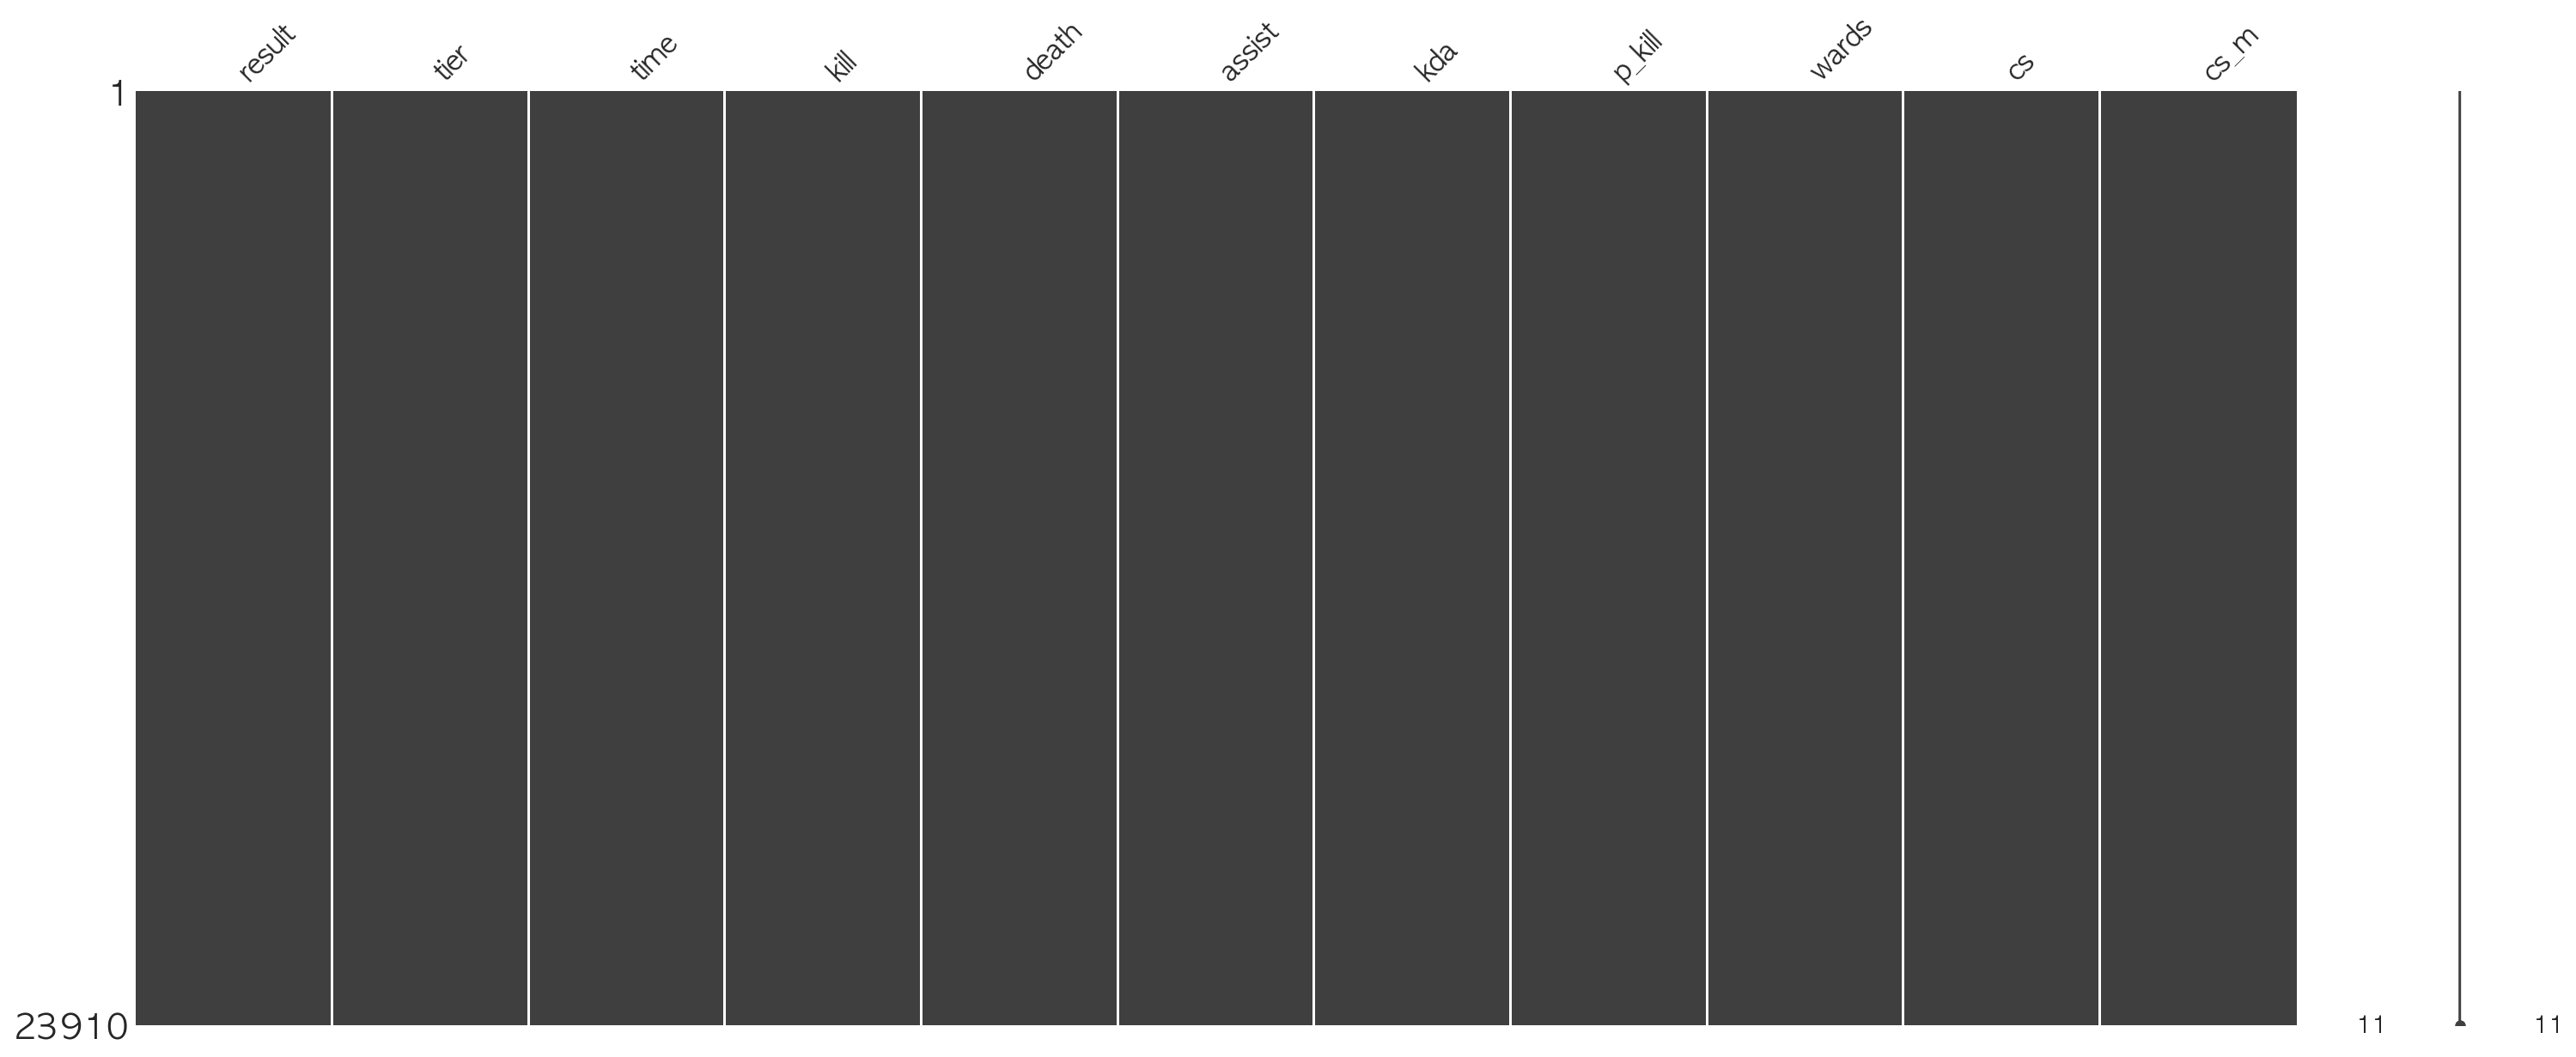

In [2]:
msno.matrix(train)

In [3]:
train.head()

result        tier   time  kill  death  assist       kda  p_kill  wards  \
0  Victory      Master  19.98   4.0    4.0     4.0  2.000000    0.33    0.0   
1  Victory  Challenger  22.37   5.0    0.0     5.0       inf    0.45    2.0   
2   Defeat   Diamond 1  15.57   1.0    5.0     1.0  0.400000    0.22    1.0   
3   Defeat   Diamond 1  22.25   9.0    6.0     6.0  2.500000    0.60    3.0   
4   Defeat      Master  24.48   2.0    5.0     8.0  2.000000    0.67    3.0   

      cs  cs_m  
0  185.0   9.3  
1  154.0   6.9  
2   67.0   4.3  
3  101.0   4.5  
4  146.0   6.0

In [4]:
train_cols = train.columns
print('There are {} columns in data'.format(len(train_cols)))
print('-'*30)
pprint(train_cols.tolist())

There are 11 columns in data
------------------------------
['result',
 'tier',
 'time',
 'kill',
 'death',
 'assist',
 'kda',
 'p_kill',
 'wards',
 'cs',
 'cs_m']


## 1. 승패와 Kill/Death/Assist의 상관관계

- 승리 시에 Kill/Assist 모두 증가
- 패배 시에는 Death가 더 많이 발생
- Kill/Death/Assist 사이의 상관관계는 약함

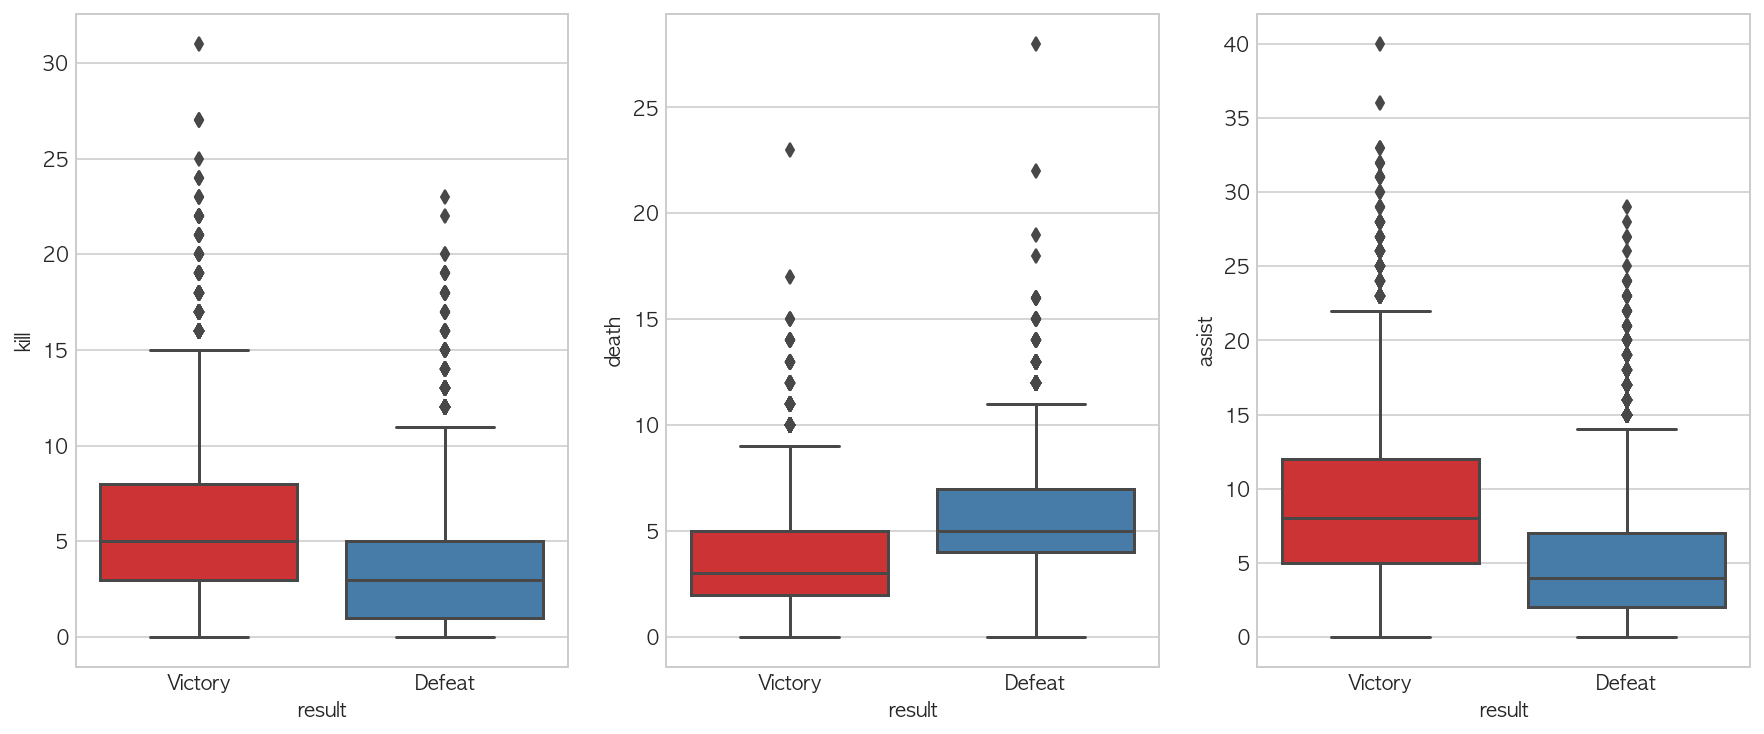

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

sns.boxplot(x=train['result'], y=train['kill'], palette='Set1', ax=axes[0])
sns.boxplot(x=train['result'], y=train['death'], palette='Set1', ax=axes[1])
sns.boxplot(x=train['result'], y=train['assist'], palette='Set1', ax=axes[2])

plt.show()

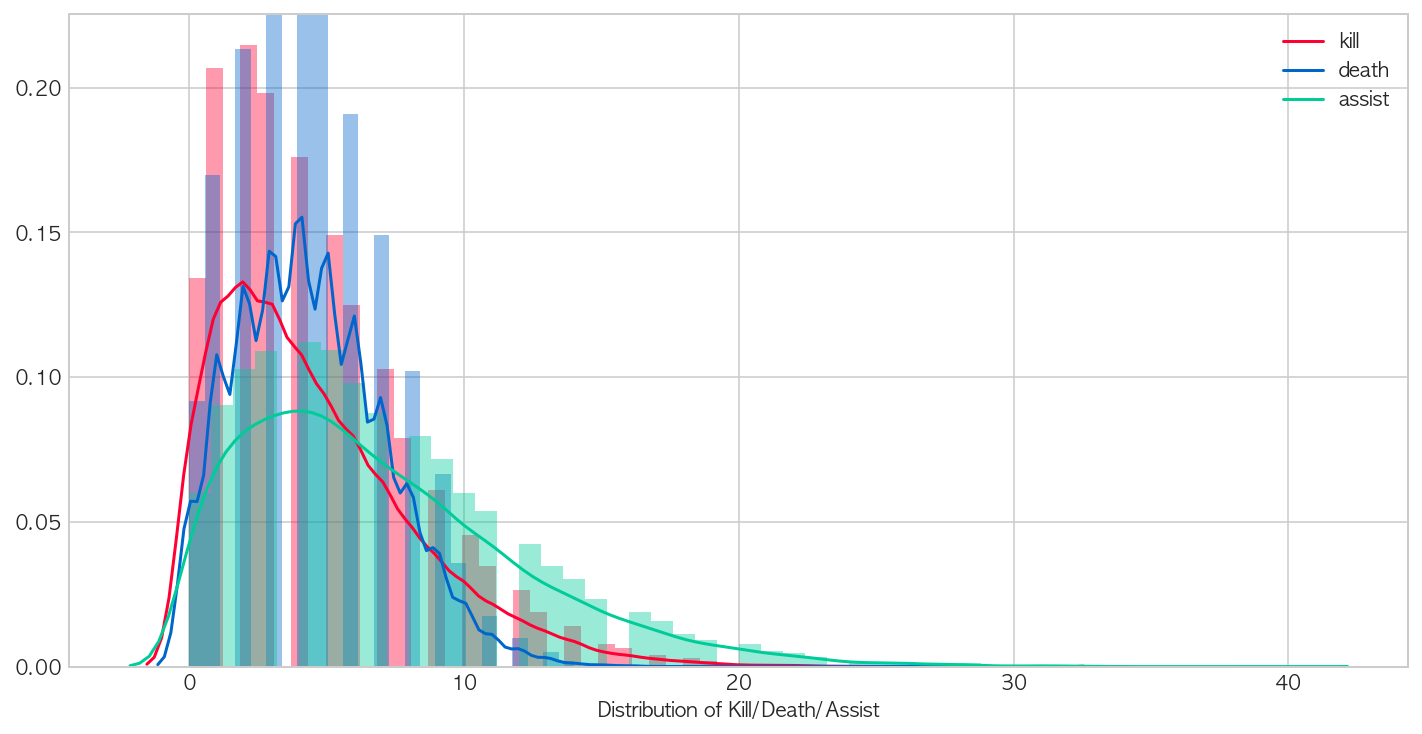

In [6]:
cols = ['kill', 'death', 'assist']
colors = ['#ff0033', '#0066cc', '#00cc99']

plt.figure(figsize=(12, 6))
for col, color in zip(cols, colors):
    sns.distplot(train[col], color=color, kde_kws={'label': col})
plt.xlabel('Distribution of Kill/Death/Assist')
plt.show()

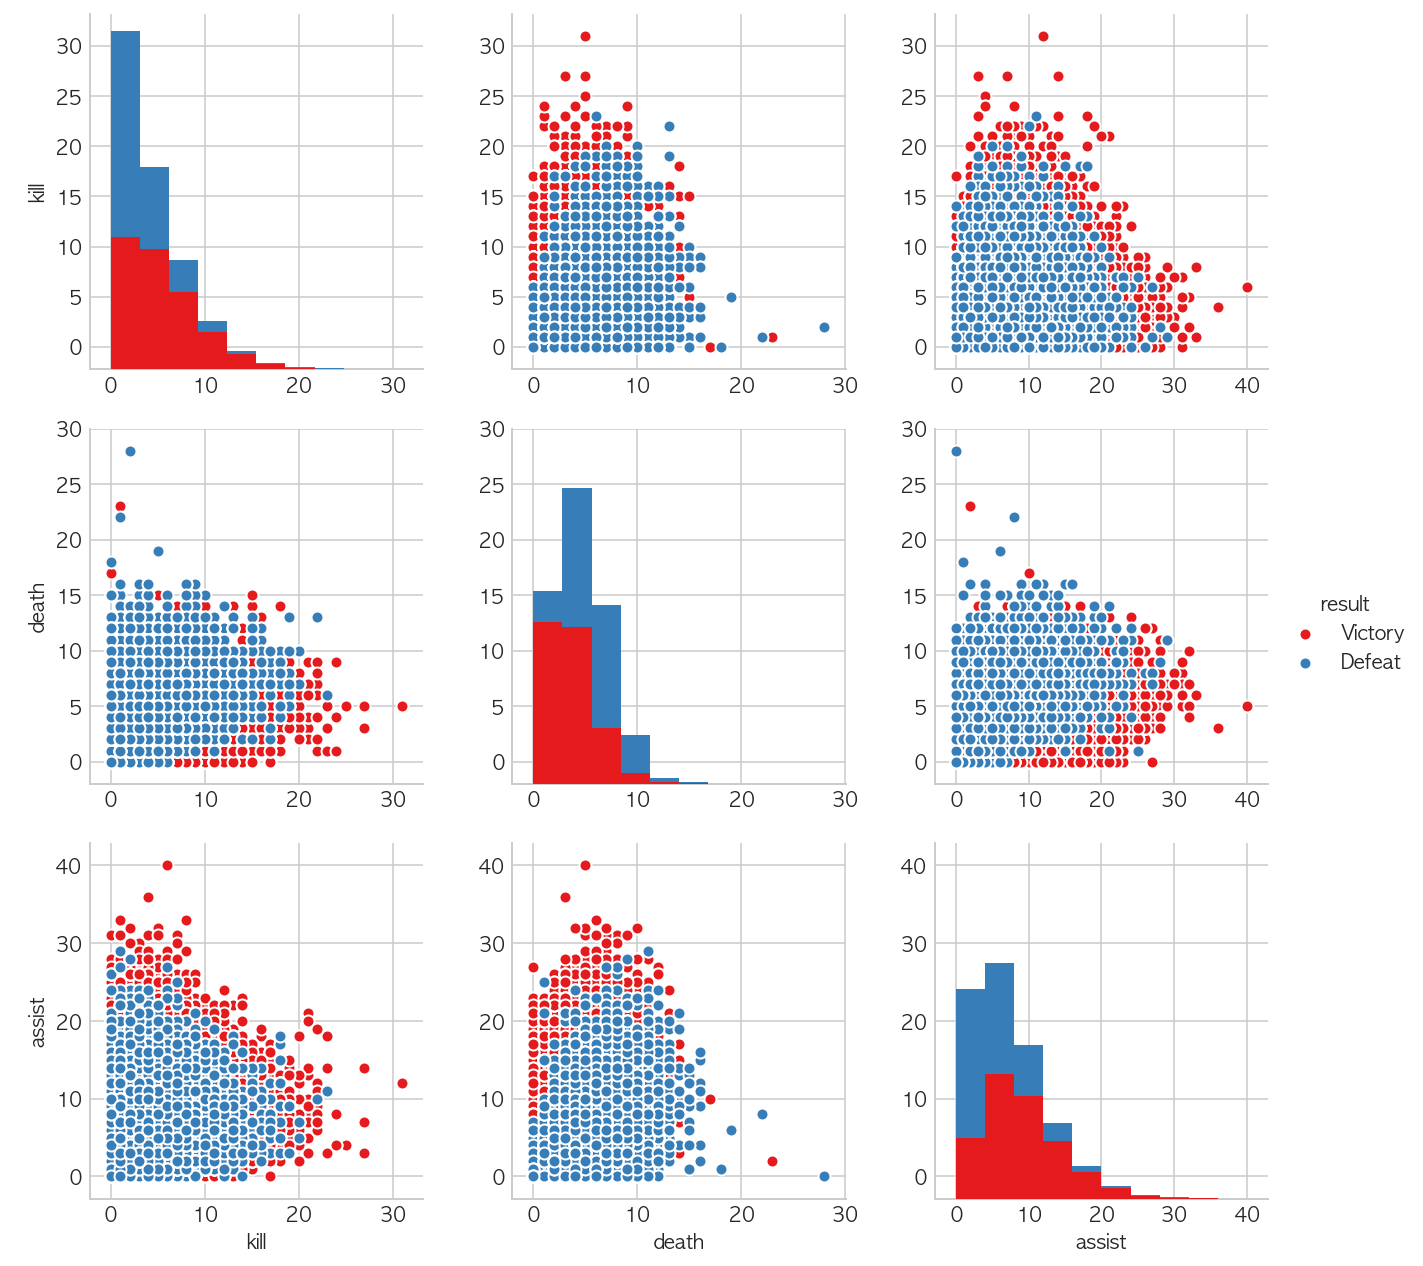

In [7]:
train_kda =  train.loc[:, ['kill', 'death', 'assist', 'result']]

sns.pairplot(train_kda, hue='result', palette='Set1', size=3)
plt.show()

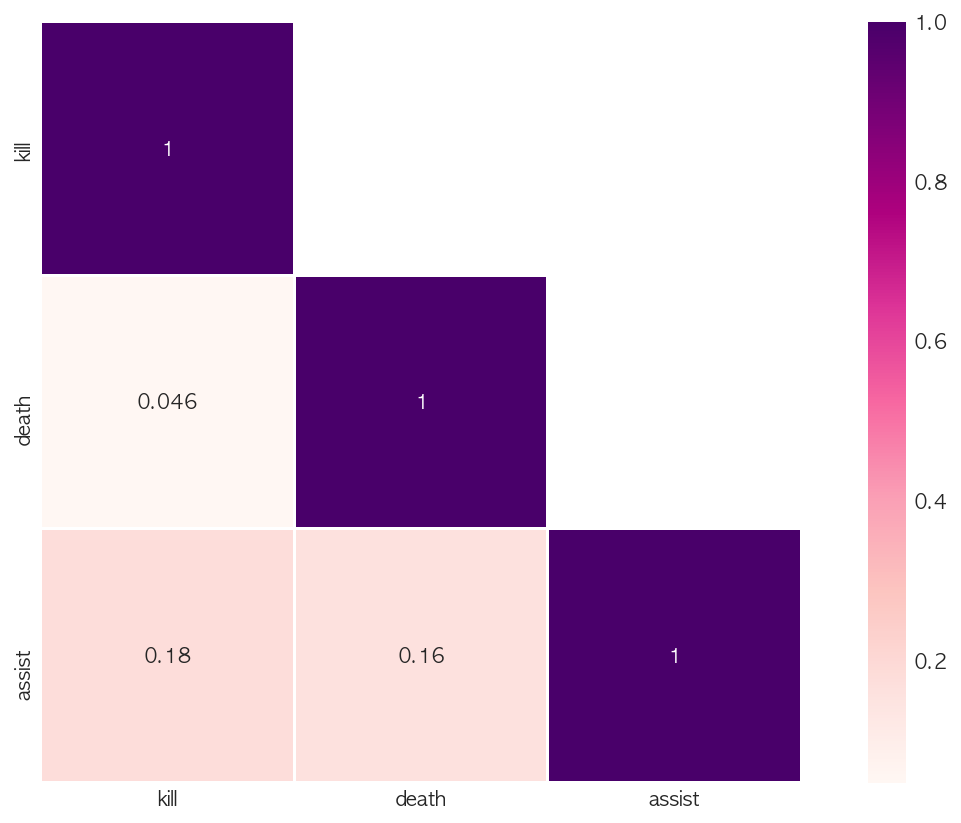

In [8]:
corr_matt = train_kda.corr()
mask = np.array(corr_matt)
mask[np.tril_indices_from(mask)] = False

fig, ax = plt.subplots()
fig.set_size_inches(12, 7)
sns.heatmap(corr_matt, mask=mask, annot=True,
            square=True, linewidths=1, cmap="RdPu")
plt.show()

## 2. CS/분당 CS/와드/플레이 시간과의 상관관계

- CS와 분당 CS 모두 승리 시 높음
- 승리 시 와드 개수가 더 많음
- 게임 결과에 따른 플레이 시간은 차이 없음

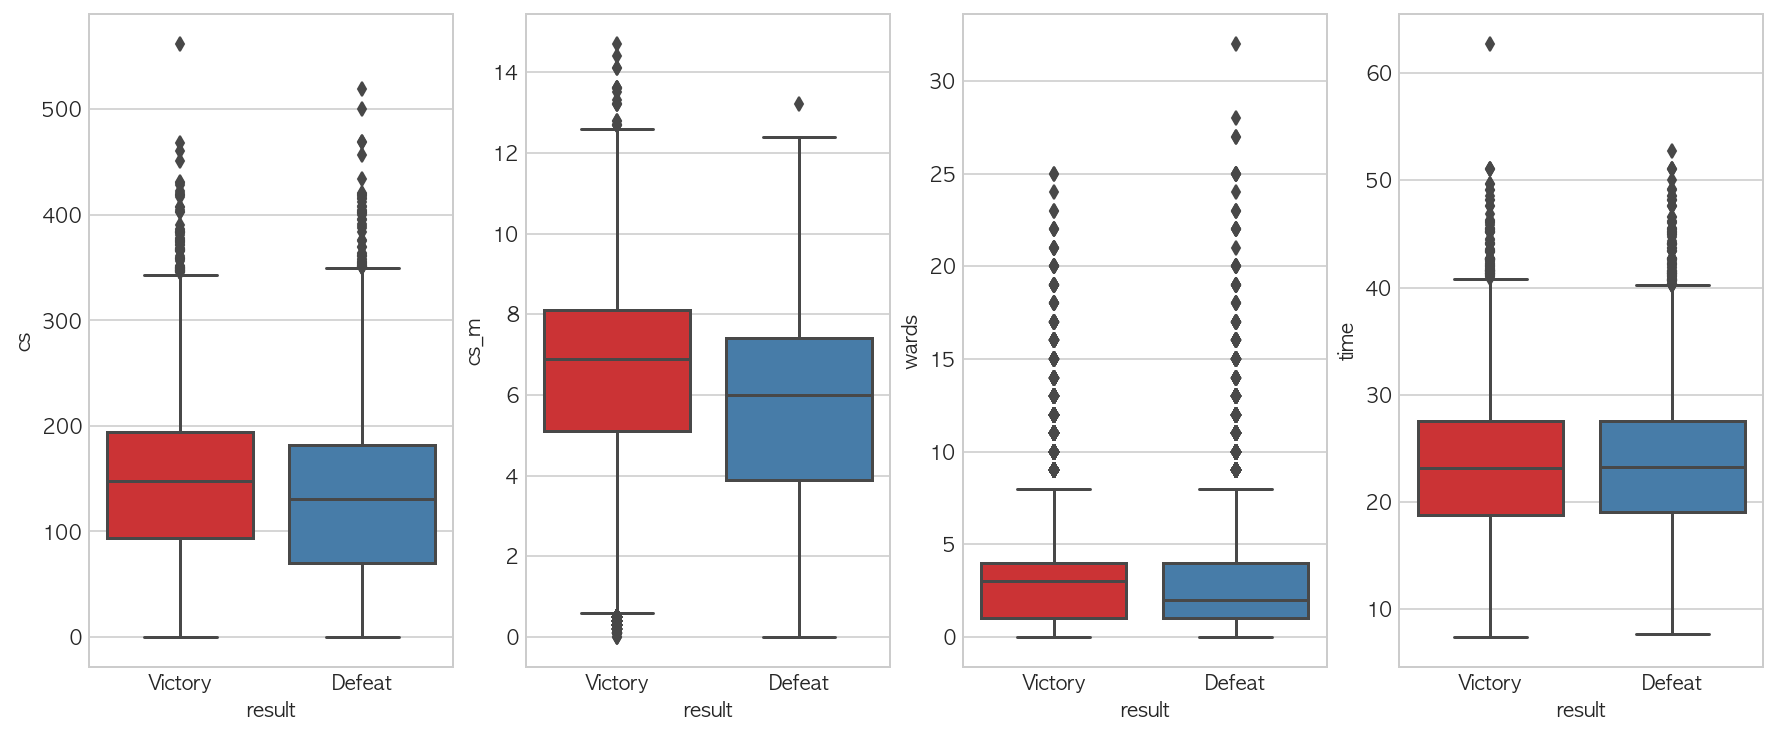

In [9]:
fig, axes = plt.subplots(1, 4, figsize=(15, 6))

sns.boxplot(x=train['result'], y=train['cs'], palette='Set1', ax=axes[0])
sns.boxplot(x=train['result'], y=train['cs_m'], palette='Set1', ax=axes[1])
sns.boxplot(x=train['result'], y=train['wards'], palette='Set1', ax=axes[2])
sns.boxplot(x=train['result'], y=train['time'], palette='Set1', ax=axes[3])
plt.show()

- 와드를 설치한 경우 승리가 조금 더 많음
- 와드의 개수가 10개가 넘어가는 경우, 경기 후반부라 승패와 큰 상관관계가 없어 보임

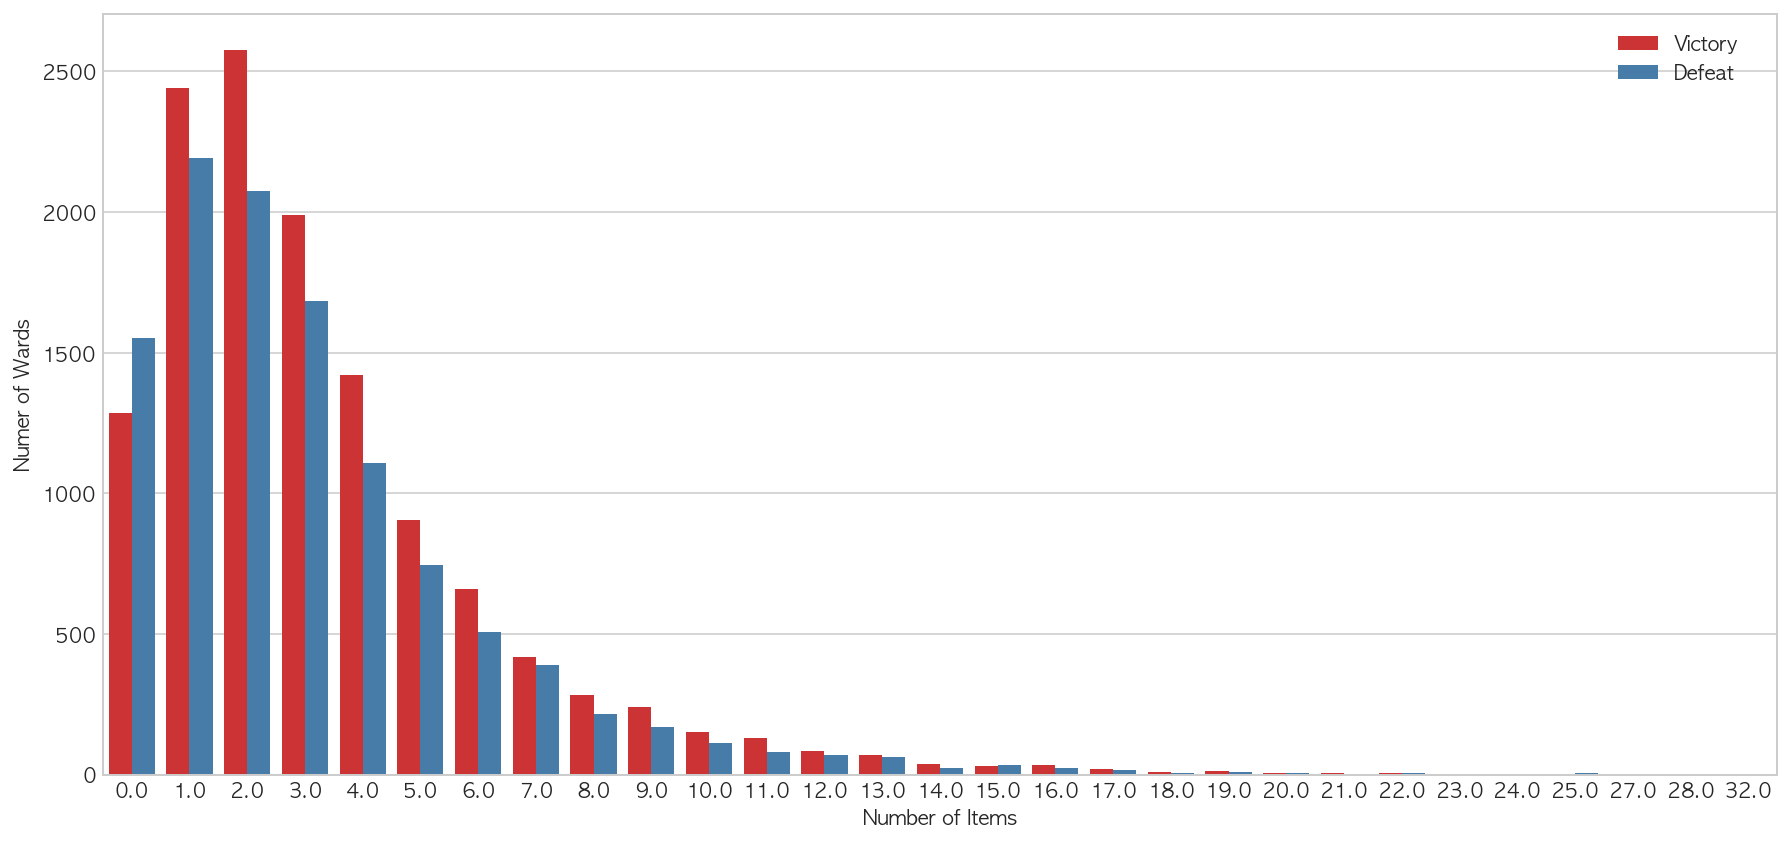

In [10]:
plt.figure(figsize=(15,7))
sns.countplot('wards',
              hue='result',
              data=train,
              palette='Set1')
plt.xlabel('Number of Items')
plt.ylabel('Numer of Wards')
plt.legend(loc=(0.9, 0.9))
plt.show()

### 2.1 분당 CS는 CS의 관계
- 분당 CS는 CS에 대해 로그 함수 형태로 증가

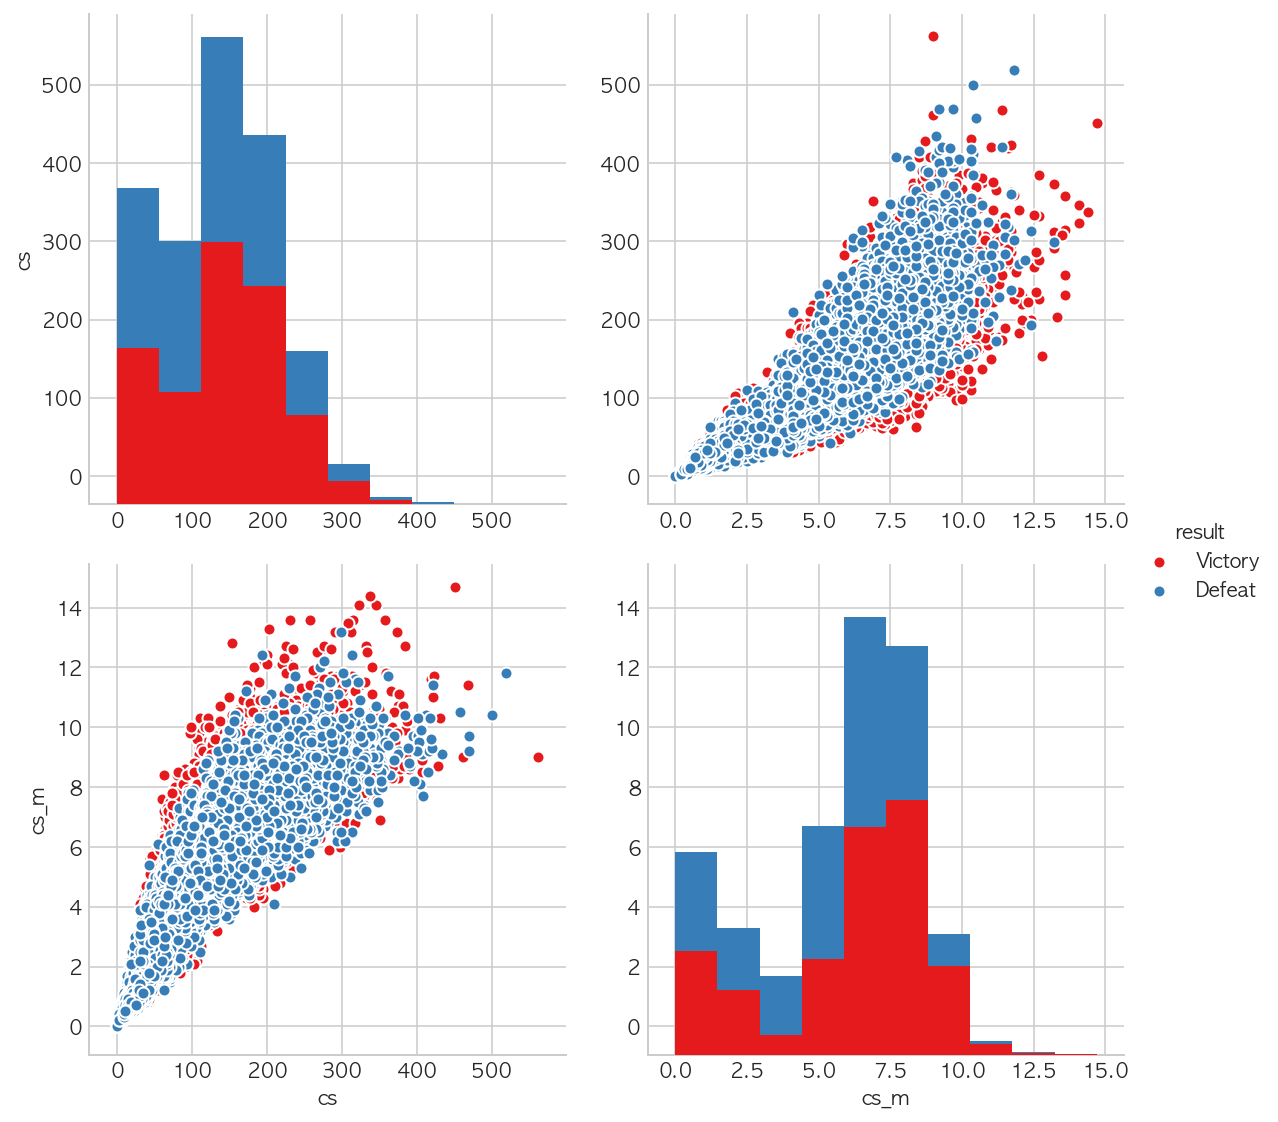

In [11]:
train_cs =  train.loc[:, ['cs', 'cs_m', 'result']]
sns.pairplot(train_cs, hue='result', palette='Set1', size=4)
plt.show()

## 3. 승패와 KDA의 상관관계

### 3.1 KDA 분포
- Perfect (Death 없음) 기록은 601건
- Perfect를 제외한 KDA 최대/최소는 35/0.14
- inf 처리: KDA 최댓값으로 패딩

In [12]:
max_kda = max(train.loc[train['kda']!=np.inf]['kda'])
min_kda = min(train.loc[train['kda']]['kda'])

print(len(train[train['kda']==np.inf]))
print(max_kda)
print(min_kda)

1196
32.0
0.4


- Perfect인 경우 97% 승리
- Perfect이면서 패배한 경우에는 Kill/Assist 모두 이긴 경우보다 낮았음

In [13]:
train[train['kda']==np.inf]['result'].value_counts()

Victory    1161
Defeat       35
Name: result, dtype: int64

In [14]:
perf = train[train['kda']==np.inf]
perf_defeat = perf[perf['result']=='Defeat']
perf_defeat.head()

result       tier   time  kill  death  assist  kda  p_kill  wards  \
9     Defeat  Diamond 1  18.12   1.0    0.0     0.0  inf    0.09    2.0   
160   Defeat  Diamond 1  11.20   1.0    0.0     1.0  inf    0.50    1.0   
322   Defeat  Diamond 1  15.93   3.0    0.0     3.0  inf    0.86    2.0   
1376  Defeat     Master  17.73   1.0    0.0     2.0  inf    0.75    3.0   
2282  Defeat     Master  21.20   0.0    0.0     1.0  inf    0.14    6.0   

         cs  cs_m  
9     157.0   8.7  
160    66.0   5.9  
322    29.0   1.8  
1376   25.0   1.4  
2282   18.0   0.8

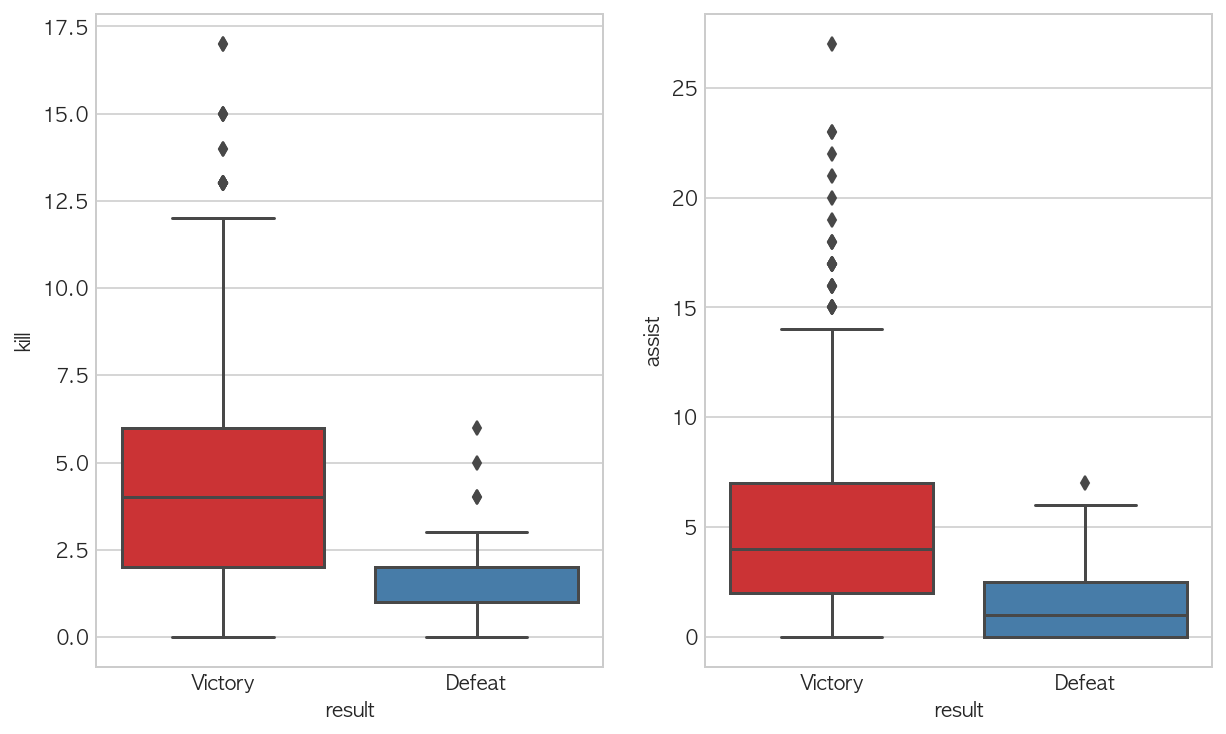

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

sns.boxplot(x=perf['result'], y=train['kill'], palette='Set1', ax=axes[0])
sns.boxplot(x=perf['result'], y=train['assist'], palette='Set1', ax=axes[1])
plt.show()

In [16]:
train[train['kda']==max_kda]

result    tier   time  kill  death  assist   kda  p_kill  wards     cs  \
13776  Defeat  Master  36.83   7.0    1.0    25.0  32.0     0.8    1.0  245.0   

       cs_m  
13776   6.7

In [17]:
print(len(train[train['kda']==min_kda]))
train[train['kda']==min_kda].head()

143


result       tier   time  kill  death  assist  kda  p_kill  wards  \
2     Defeat  Diamond 1  15.57   1.0    5.0     1.0  0.4    0.22    1.0   
441   Defeat  Diamond 1  20.12   1.0    5.0     1.0  0.4    0.20    1.0   
944   Defeat     Master  26.08   1.0    5.0     1.0  0.4    0.18    1.0   
954   Defeat     Master  15.27   1.0    5.0     1.0  0.4    0.33    2.0   
1016  Defeat  Diamond 1  27.80   0.0   10.0     4.0  0.4    0.36    5.0   

         cs  cs_m  
2      67.0   4.3  
441   169.0   8.4  
944   211.0   8.1  
954    17.0   1.1  
1016  186.0   6.7

- Perfect KDA는 최댓값으로 Padding (KDA 3 이상은 큰 의미가 없다고 판단)

In [18]:
idx = train['kda']==np.inf
train.loc[idx, 'kda'] = max_kda
len(train[train['kda']==np.inf])

0

### 3.2 KDA 1 (1인분) 이상/미만 경우

- KDA 1 이상일 경우, 승리할 확률 증가
- KDA 1 미만인 경우에는 대부분 패배

In [19]:
kda_over_1 = train[train['kda'] >= 1.00]
kda_under_1 = train[train['kda'] < 1.00]

print(len(kda_over_1))
print(len(kda_under_1))

20436
3474


In [20]:
victory = train['result'].value_counts()[0]
defeat = train['result'].value_counts()[1]

r_victory = victory / len(train)
r_defeat = defeat / len(train)

print(round(r_victory, 2), round(r_defeat, 2))

0.54 0.46


In [21]:
print('KDA 1이상인 경우 승패: ')
print(dict(kda_over_1['result'].value_counts()))
print('')
print('KDA 1이하인 경우 승패: ')
print(dict(kda_under_1['result'].value_counts()))

KDA 1이상인 경우 승패: 
{'Victory': 12666, 'Defeat': 7770}

KDA 1이하인 경우 승패: 
{'Defeat': 3330, 'Victory': 144}


In [22]:
victory = kda_over_1['result'].value_counts()[0]
defeat = kda_over_1['result'].value_counts()[1]

r_victory = victory / len(kda_over_1)
r_defeat = defeat / len(kda_over_1)

print(round(r_victory, 2), round(r_defeat, 2))

0.62 0.38


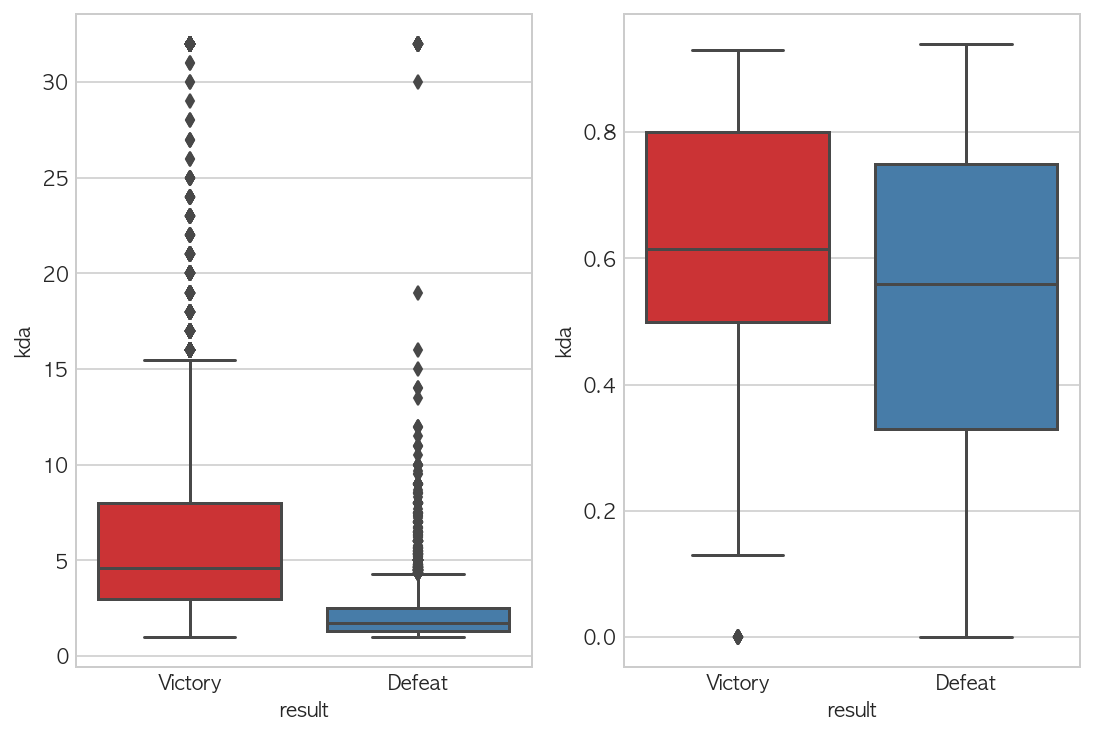

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(9, 6))

sns.boxplot(x=kda_over_1['result'], y=train['kda'],
            palette='Set1', ax=axes[0])
sns.boxplot(x=kda_under_1['result'], y=train['kda'],
            order=['Victory', 'Defeat'], palette='Set1', ax=axes[1])
plt.show()

### 3.3 승패와 구간별 KDA

- KDA 2 미만이면 패배가 더 많음
- KDA 2점대에서는 승패가 비슷
- KDA 3이상에서는 승리가 더 많음

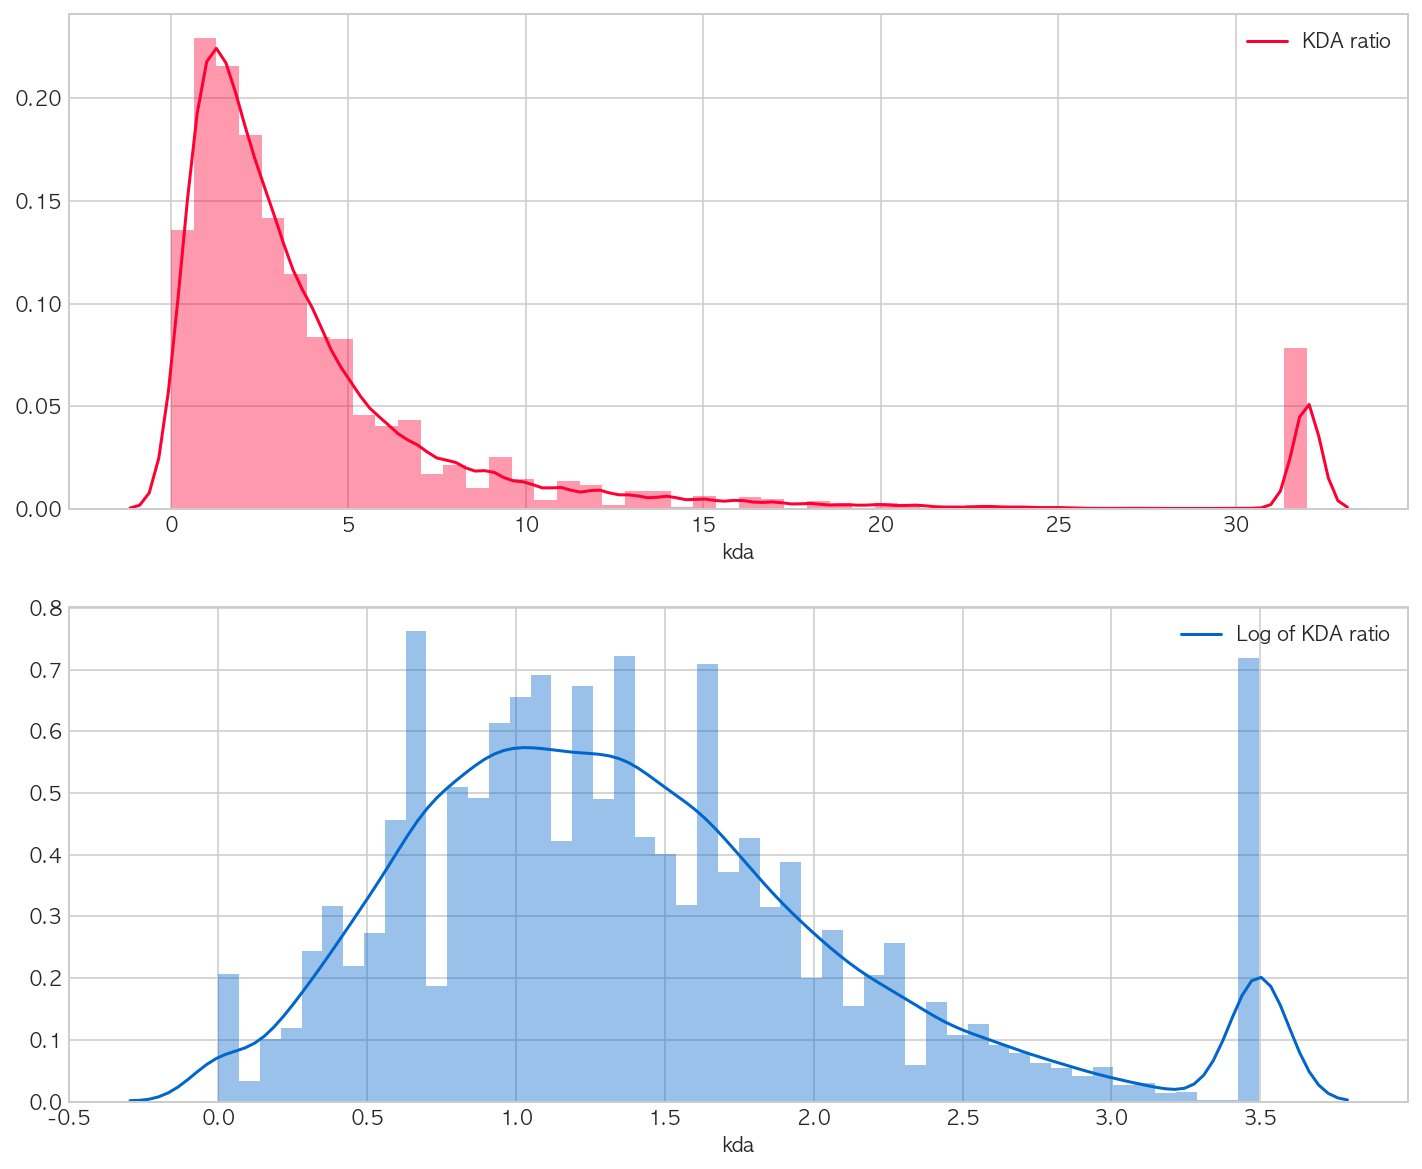

In [24]:
plt.figure(figsize=(12, 10))

plt.subplot(211)
sns.distplot(train[train['kda']!=np.inf]['kda'], 
             color=colors[0],
             kde_kws={'label': 'KDA ratio'})
plt.subplot(212)
sns.distplot(np.log1p(train[train['kda']!=np.inf]['kda']), 
             color=colors[1],
             kde_kws={'label': 'Log of KDA ratio'})
plt.show()

In [25]:
train['kda_range'] = train['kda'].apply(categorize_kda)
train['kda_range'].value_counts()

3    11097
1     5419
2     3920
0     3474
Name: kda_range, dtype: int64

In [93]:
kda_range_groupd = train.pivot_table(values='time', 
                                     index='result',
                                     columns=['kda_range'],
                                     aggfunc='count')
kda_range_groupd

kda_range     0     1     2     3
result                           
Defeat     3330  4413  1996  1361
Victory     144  1006  1924  9736

In [146]:
trace1 = go.Bar(
    x=kda_range_groupd.columns,
    y=kda_range_groupd.loc['Victory'],
    marker=dict(
        color=colors[0]
    ),
    name='Victory',
    opacity=0.8
)

trace2 = go.Bar(
    x=kda_range_groupd.columns,
    y=kda_range_groupd.loc['Defeat'],
    marker=dict(
        color=colors[1]
    ),
    name='Defeat',
    opacity=0.8
)

data = [trace1, trace2]
layout = go.Layout(
    title='Distribution of Result by KDA Range',
    barmode='group',
    margin=go.Margin(
        l=50,
        r=50,
        b=100,
        t=100,
    ),
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

## 4. 승패와 티어간 상관관계

In [136]:
tier_info = list(train['tier'].unique())
tier_pivot = train.pivot_table(values='time', 
                               index='result',
                               columns=['tier'],
                               aggfunc='count')
tier_pivot = tier_pivot[tier_info]
tier_pivot

tier     Master  Challenger  Diamond 1  Diamond 2
result                                           
Defeat     4022        1250       5605        223
Victory    4936        1506       6204        164

In [144]:
data = []
for idx, val in enumerate(train['result'].unique()):
    trace = go.Bar(
        x=tier_pivot.columns,
        y=tier_pivot.loc[val],
        marker=dict(
            color=colors[idx]
        ),
        name=val,
        opacity=0.8
    )
    data.append(trace)

layout = go.Layout(
    title='Distribution of Result by Tier',
    barmode='group',
    margin=go.Margin(
        l=50,
        r=50,
        b=100,
        t=100,
    ),
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

In [170]:
data = []
for i in range(len(tier_info)):
    trace = go.Box(
        x=list(train[train['tier']==tier_info[i]]['result']),
        y=list(train[train['tier']==tier_info[i]]['kda']),
        name=tier_info[i]
    )
    data.append(trace)

layout = go.Layout(
    yaxis=dict(
        title='KDA',
        zeroline=False
    ),
    boxmode='group', 
    title='KDA by Tier/Result'
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

In [169]:
data = []
for i in range(len(tier_info)):
    trace = go.Box(
        x=list(train[train['tier']==tier_info[i]]['result']),
        y=list(train[train['tier']==tier_info[i]]['p_kill']),
        name=tier_info[i]
    )
    data.append(trace)

layout = go.Layout(
    yaxis=dict(
        title='Contribution to Total Kill',
        zeroline=False
    ),
    boxmode='group', 
    title='Kill Contribution by Tier/Result'
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

## 5. 전체 변수간 상관관계

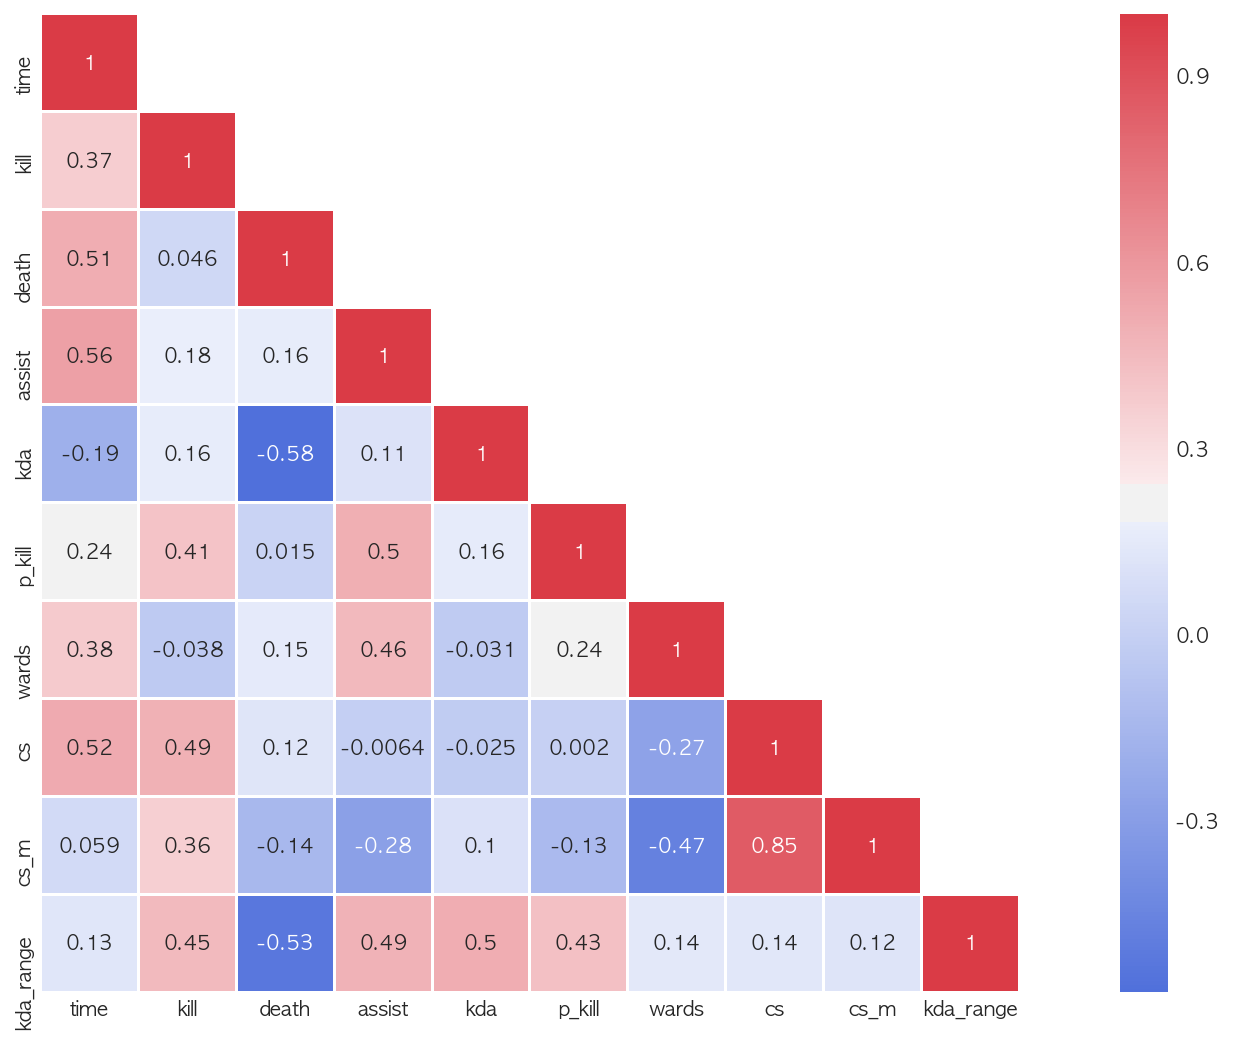

In [72]:
matt = train.iloc[:, 1:]

corr_matt = matt.corr()
mask = np.array(corr_matt)
mask[np.tril_indices_from(mask)] = False
cmap = sns.diverging_palette(-100, 10, as_cmap=True)

fig, ax = plt.subplots()
fig.set_size_inches(18, 9)
sns.heatmap(corr_matt, mask=mask, annot=True,
            square=True, linewidths=1, cmap=cmap)
plt.show()